In [ ]:
# %%shell
# # Installs the latest dev build of TVM from PyPI. If you wish to build
# # from source, see https://tvm.apache.org/docs/install/from_source.html
# pip install apache-tvm --pre

# 编译 ONNX 模型

**作者**: [Joshua Z. Zhang](https://zhreshold.github.io/)


本文是使用 Relay 部署 ONNX 模型的入门教程。

安装一些包：

In [ ]:
%%bash
pip install onnx onnxoptimizer

或者直接访问 [ONNX 官方网站](https://github.com/onnx/onnx)。

In [ ]:
import onnx
import numpy as np
import tvm
from tvm import te
import tvm.relay as relay
from tvm.contrib.download import download_testdata

## 加载预训练 ONNX 模型

这里使用超分辨率模型 [super_resolution_with_caffe2](http://pytorch.org/tutorials/advanced/super_resolution_with_caffe2.html)，并下载保存的 onnx 模型：


In [ ]:
model_url = "".join(
    [
        "https://gist.github.com/zhreshold/",
        "bcda4716699ac97ea44f791c24310193/raw/",
        "93672b029103648953c4e5ad3ac3aadf346a4cdc/",
        "super_resolution_0.2.onnx",
    ]
)
model_path = download_testdata(model_url, "super_resolution.onnx", module="onnx")
# now you have super_resolution.onnx on disk
onnx_model = onnx.load(model_path)

## 加载测试图片

该模型输入大小为 $224 \times 224$ 的单个输入图像，并沿每个轴输出比输入大 $3$ 倍的缩放图像，即 $672 \times 672$ 图像。重新缩放猫图像以适应这个输入形状，然后转换为 `YCbCr`。然后将超分辨率模型应用于亮度 (`Y`) 通道。

In [8]:
from PIL import Image

img_url = "https://github.com/dmlc/mxnet.js/blob/main/data/cat.png?raw=true"
img_path = download_testdata(img_url, "cat.png", module="data")
img = Image.open(img_path).resize((224, 224))
img_ycbcr = img.convert("YCbCr")  # convert to YCbCr
img_y, img_cb, img_cr = img_ycbcr.split()
x = np.array(img_y)[np.newaxis, np.newaxis, :, :]

## 使用 relay 编译模型

通常，ONNX 模型将模型输入值与参数值混合在一起，输入名称为 `1`。此模型依赖于，您应该检查您的模型的文档，以确定完整的输入和参数名称空间。

将 `shape` 字典传递给 {func}`~tvm.relay.frontend.from_onnx` 方法，告诉 `relay` 哪些 ONNX 参数是输入，哪些是参数，并提供了输入大小的静态定义。

In [ ]:
target = "llvm"

input_name = "1"
shape_dict = {input_name: x.shape}
mod, params = relay.frontend.from_onnx(onnx_model, shape_dict)

with tvm.transform.PassContext(opt_level=1):
    executor = relay.build_module.create_executor(
        "graph", mod, tvm.cpu(0), target, params
    ).evaluate()

## 在 TVM 上执行



In [10]:
dtype = "float32"
tvm_output = executor(tvm.nd.array(x.astype(dtype))).numpy()

## 展示结果

将输入图像和输出图像放在一起。亮度（luminance）通道 `Y` 是模型的输出。调整色度（chroma）通道 `Cb` 和 `Cr` 的大小，以匹配简单的双三次算法（bicubic algorithm）。然后将图像重新组合并转换回 `RGB`。

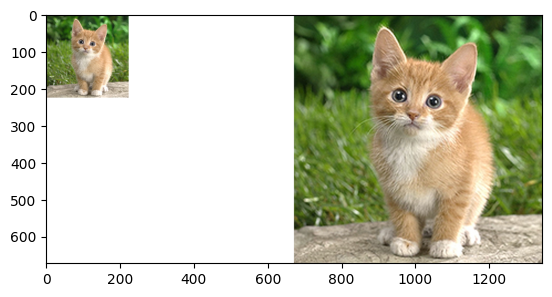

In [11]:
from matplotlib import pyplot as plt

out_y = Image.fromarray(np.uint8((tvm_output[0, 0]).clip(0, 255)), mode="L")
out_cb = img_cb.resize(out_y.size, Image.BICUBIC)
out_cr = img_cr.resize(out_y.size, Image.BICUBIC)
result = Image.merge("YCbCr", [out_y, out_cb, out_cr]).convert("RGB")
canvas = np.full((672, 672 * 2, 3), 255)
canvas[0:224, 0:224, :] = np.asarray(img)
canvas[:, 672:, :] = np.asarray(result)
plt.imshow(canvas.astype(np.uint8))
plt.show()

```{note}
默认情况下，ONNX 根据动态形状定义模型。ONNX 导入器在导入时保留这种动态性，而编译器试图在编译时将模型转换为静态形状。如果失败，模型中仍然可能有动态操作。并不是所有的 TVM 内核目前都支持动态形状，如果您在使用动态内核时遇到错误，请在 discuss.tvm.apache.org 上提交 issue。

这个特定的模型是使用旧版本的 ONNX 构建的。在导入阶段，ONNX 导入器将运行 ONNX 验证器，这可能会抛出 `Mismatched attribute type` 警告。因为 TVM 支持许多不同的 ONNX 版本，所以 Relay 模型仍然有效。
```